
# Cluster Analysis Course Notebook

### Importing Data files

In [48]:
#Import Product DataSet here
import types
import pandas as pd
from botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_26e37d9843024cf7924f9fc18e1447d0 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='QcRV-3oXtA2OuOTaroL_tLBVzbuQzRj2cstOeCxfqt5_',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_26e37d9843024cf7924f9fc18e1447d0.get_object(Bucket='project1-donotdelete-pr-m5oqgyaljasxsb',Key='DNA - Product Data Set - Student 2 of 3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

product_data = pd.read_csv(body,sep='|')
product_data.head()



,PRODUCT CODE,PRODUCT CATEGORY,UNIT LIST PRICE
0,30001,HEALTH & BEAUTY,$7.45
1,30002,HEALTH & BEAUTY,$5.35
2,30003,HEALTH & BEAUTY,$5.49
3,30004,HEALTH & BEAUTY,$6.46
4,30005,HEALTH & BEAUTY,$7.33


In [50]:
#Import Transactions
body = client_26e37d9843024cf7924f9fc18e1447d0.get_object(Bucket='project1-donotdelete-pr-m5oqgyaljasxsb',Key='DNA- Transaction Data Set - Student 3 of 3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

transactions_data = pd.read_csv(body,sep='|')
transactions_data.head()



,CUSTOMER NUM,PRODUCT NUM,QUANTITY PURCHASED,DISCOUNT TAKEN,TRANSACTION DATE,STOCKOUT
0,10114,30011,4,0.0,1/2/2015,0
1,10217,30016,3,0.0,1/2/2015,0
2,10224,30013,4,0.0,1/2/2015,0
3,10103,30012,3,0.2,1/2/2015,0
4,10037,30010,8,0.0,1/2/2015,0


In [51]:
#Import Customer Dataset Her
body = client_26e37d9843024cf7924f9fc18e1447d0.get_object(Bucket='project1-donotdelete-pr-m5oqgyaljasxsb',Key='DNA - Customer Data Set - Student 1 of 3.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

customer_data = pd.read_csv(body)
customer_data.head()



,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS
0,10001,0,64,"$133,498",5,enrolled,06-03-2013,4,Single
1,10002,0,42,"$94,475",9,notenrolled,NaN,6,Married
2,10003,0,40,"$88,610",9,enrolled,02-09-2010,5,Married
3,10004,0,38,"$84,313",8,enrolled,06-04-2015,1,Single
4,10005,0,30,"$51,498",3,notenrolled,NaN,1,Single


### Changing data types

In [52]:
customer_data['INCOME']=customer_data['INCOME'].map(lambda x : x.replace('$',''))

In [53]:
customer_data['INCOME']=customer_data['INCOME'].map(lambda x : int(x.replace(',','')))

### Creating Customer View

In [54]:
trans_products=transactions_data.merge(product_data,how='inner', left_on='PRODUCT NUM', right_on='PRODUCT CODE')

In [55]:
trans_products['UNIT LIST PRICE']=trans_products['UNIT LIST PRICE'].map(lambda x : float(x.replace('$','')))

In [56]:
trans_products['Total_Price']=trans_products['QUANTITY PURCHASED'] * trans_products['UNIT LIST PRICE'] * (1- trans_products['DISCOUNT TAKEN'])

In [57]:
customer_prod_categ=trans_products.groupby(['CUSTOMER NUM','PRODUCT CATEGORY']).agg({'Total_Price':'sum'})

In [58]:
customer_prod_categ=customer_prod_categ.reset_index()

In [59]:
customer_pivot=customer_prod_categ.pivot(index='CUSTOMER NUM',columns='PRODUCT CATEGORY',values='Total_Price')

In [60]:
trans_total_spend=trans_products.groupby('CUSTOMER NUM').agg({'Total_Price':'sum'}).\
rename(columns={'Total_Price':'TOTAL SPENT'})

In [61]:
customer_KPIs=customer_pivot.merge(trans_total_spend,how='inner',left_index=True, right_index=True )

In [62]:
customer_KPIs=customer_KPIs.fillna(0)


In [63]:
customer_all_view=customer_data.merge(customer_KPIs,how='inner', left_on='CUSTOMERID', right_index=True)

In [64]:
customer_all_view.head()

,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS,APPAREL,ELECTRONICS,FOOD,HEALTH & BEAUTY,TOTAL SPENT
0,10001,0,64,133498,5,enrolled,06-03-2013,4,Single,4022.430,1601.315,68.688,1134.337,6826.770
1,10002,0,42,94475,9,notenrolled,NaN,6,Married,2312.509,2473.163,276.779,0.000,5062.451
2,10003,0,40,88610,9,enrolled,02-09-2010,5,Married,2887.382,5414.418,260.640,0.000,8562.440
3,10004,0,38,84313,8,enrolled,06-04-2015,1,Single,3637.213,1840.211,45.270,0.000,5522.694
4,10005,0,30,51498,3,notenrolled,NaN,1,Single,213.512,0.000,0.000,0.000,213.512


# Clustering  

In [65]:
#Begin Writing your code here
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

In [66]:
cluster_input=customer_all_view[['INCOME','TOTAL SPENT']]
cluster_input.head(5)

,INCOME,TOTAL SPENT
0,133498,6826.770
1,94475,5062.451
2,88610,8562.440
3,84313,5522.694
4,51498,213.512


In [67]:
Kmeans_model=KMeans(n_clusters=4)

In [68]:
Kmeans_model

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=4, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [69]:
cluster_output = Kmeans_model.fit_predict(cluster_input)

In [70]:
cluster_output

array([0, 3, 3, 3, 1, 0, 3, 2, 2, 3, 1, 2, 3, 3, 1, 3, 3, 2, 0, 1, 2, 2, 2,
       1, 2, 2, 3, 1, 1, 0, 3, 1, 1, 3, 1, 1, 1, 2, 2, 1, 1, 3, 3, 3, 0, 1,
       1, 3, 0, 1, 2, 1, 1, 1, 2, 1, 2, 2, 2, 1, 3, 2, 0, 2, 0, 3, 3, 2, 1,
       3, 3, 1, 1, 3, 0, 1, 3, 1, 3, 0, 3, 2, 0, 2, 1, 2, 0, 1, 3, 1, 2, 0,
       2, 2, 2, 3, 2, 1, 0, 2, 1, 1, 1, 1, 3, 2, 2, 1, 3, 1, 1, 1, 3, 1, 2,
       1, 0, 0, 3, 3, 1, 3, 2, 1, 3, 3, 2, 3, 1, 0, 3, 3, 1, 3, 0, 3, 0, 0,
       2, 3, 3, 1, 1, 1, 3, 2, 3, 1, 2, 3, 3, 2, 2, 2, 3, 2, 1, 1, 2, 1, 0,
       1, 0, 2, 1, 3, 1, 0, 3, 1, 0, 1, 2, 2, 0, 1, 0, 0, 2, 1, 0, 1, 3, 1,
       2, 0, 2, 2, 1, 0, 1, 2, 2, 0, 2, 0, 2, 0, 2, 3, 2, 1, 0, 0, 2, 1, 3,
       0, 0, 0, 0, 1, 2, 3, 0, 2, 1, 2, 3, 1, 3, 1, 2, 1, 1, 1, 2, 1, 1, 3,
       2, 3, 2, 3, 3, 1, 2, 0, 1, 1, 1, 3, 3, 3, 3, 1, 2, 2, 0, 1, 3, 2, 1,
       2, 1, 3, 1, 0, 2, 2, 1, 0, 1, 3, 3, 0, 2, 3, 3, 2, 0, 1, 0, 1, 1, 1,
       0, 3, 2, 2, 2, 3, 3, 3, 0, 3, 2, 3, 2, 0, 0, 1, 1, 0, 1, 1, 1, 1, 3,
       3, 1,

In [71]:
type(cluster_output)

numpy.ndarray

In [72]:
product_data.head()

,PRODUCT CODE,PRODUCT CATEGORY,UNIT LIST PRICE
0,30001,HEALTH & BEAUTY,$7.45
1,30002,HEALTH & BEAUTY,$5.35
2,30003,HEALTH & BEAUTY,$5.49
3,30004,HEALTH & BEAUTY,$6.46
4,30005,HEALTH & BEAUTY,$7.33


In [73]:
product_data.head().values

array([[30001, 'HEALTH & BEAUTY', ' $7.45 '],
       [30002, 'HEALTH & BEAUTY', ' $5.35 '],
       [30003, 'HEALTH & BEAUTY', ' $5.49 '],
       [30004, 'HEALTH & BEAUTY', ' $6.46 '],
       [30005, 'HEALTH & BEAUTY', ' $7.33 ']], dtype=object)

In [74]:
product_data.head().values[1,2]

' $5.35 '

In [75]:
product_data.head().values[1,:]

array([30002, 'HEALTH & BEAUTY', ' $5.35 '], dtype=object)

In [76]:
product_data.head().values[:,2]

array([' $7.45 ', ' $5.35 ', ' $5.49 ', ' $6.46 ', ' $7.33 '], dtype=object)

In [82]:
cluster_output_pd=pd.DataFrame(cluster_output,columns=['segment'])

In [83]:
cluster_output_pd.head()

,segment
0,0
1,3
2,3
3,3
4,1


In [84]:
segment_DF=pd.concat([cluster_input,cluster_output_pd],axis=1)

In [85]:
segment_DF.head()

,INCOME,TOTAL SPENT,segment
0,133498,6826.770,0
1,94475,5062.451,3
2,88610,8562.440,3
3,84313,5522.694,3
4,51498,213.512,1


In [86]:
Kmeans_model.cluster_centers_

array([[ 138629.34482759,    6996.87572414],
       [  40510.09803922,    2472.75349673],
       [ 111789.98360656,    7856.9202541 ],
       [  79703.36956522,    5428.75010145]])

In [87]:
segment_DF[segment_DF.segment==0].head()

,INCOME,TOTAL SPENT,segment
0,133498,6826.770,0
5,132893,5234.847,0
18,137128,8021.160,0
29,144108,6866.584,0
44,143119,7469.745,0


In [88]:
import matplotlib.pyplot as plt

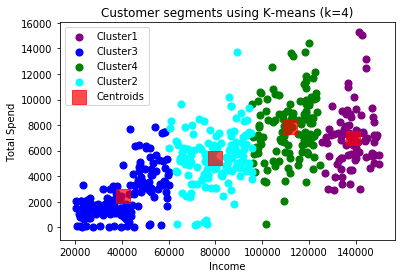

In [89]:
plt.scatter(segment_DF[segment_DF.segment==0]['INCOME'],segment_DF[segment_DF.segment==0]['TOTAL SPENT'],s=50, c='purple',label='Cluster1')

plt.scatter(segment_DF[segment_DF.segment==1]['INCOME'],segment_DF[segment_DF.segment==1]['TOTAL SPENT'],s=50, c='blue',label='Cluster3')

plt.scatter(segment_DF[segment_DF.segment==2]['INCOME'],segment_DF[segment_DF.segment==2]['TOTAL SPENT'],s=50, c='green',label='Cluster4')

plt.scatter(segment_DF[segment_DF.segment==3]['INCOME'],segment_DF[segment_DF.segment==3]['TOTAL SPENT'],s=50, c='cyan',label='Cluster2')

plt.scatter(Kmeans_model.cluster_centers_[:,0], Kmeans_model.cluster_centers_[:,1],s=200,marker='s', c='red', alpha=0.7, label='Centroids')

plt.title('Customer segments using K-means (k=4)')

plt.xlabel('Income')

plt.ylabel('Total Spend')

plt.legend()

plt.show()

In [90]:

customer_demographics=pd.concat([customer_all_view,cluster_output_pd],axis=1)


customer_demographics.head()


,CUSTOMERID,GENDER,AGE,INCOME,EXPERIENCE SCORE,LOYALTY GROUP,ENROLLMENT DATE,HOUSEHOLD SIZE,MARITAL STATUS,APPAREL,ELECTRONICS,FOOD,HEALTH & BEAUTY,TOTAL SPENT,segment
0,10001,0,64,133498,5,enrolled,06-03-2013,4,Single,4022.430,1601.315,68.688,1134.337,6826.770,0
1,10002,0,42,94475,9,notenrolled,NaN,6,Married,2312.509,2473.163,276.779,0.000,5062.451,3
2,10003,0,40,88610,9,enrolled,02-09-2010,5,Married,2887.382,5414.418,260.640,0.000,8562.440,3
3,10004,0,38,84313,8,enrolled,06-04-2015,1,Single,3637.213,1840.211,45.270,0.000,5522.694,3
4,10005,0,30,51498,3,notenrolled,NaN,1,Single,213.512,0.000,0.000,0.000,213.512,1


In [91]:
customer_demographics.groupby('segment').agg({'AGE':'mean','HOUSEHOLD SIZE':'median'})

,HOUSEHOLD SIZE,AGE
segment,,
0,2.0,73.609195
1,2.0,25.104575
2,3.0,48.032787
3,3.5,36.615942


In [92]:
def percent_loyalty(series):
    percent=100 * series.value_counts()['enrolled'] /series.count()
    return percent

In [93]:
customer_demographics.groupby('segment').agg({'AGE':'mean','HOUSEHOLD SIZE':'median','LOYALTY GROUP': percent_loyalty})

,HOUSEHOLD SIZE,AGE,LOYALTY GROUP
segment,,,
0,2.0,73.609195,65.517241
1,2.0,25.104575,50.326797
2,3.0,48.032787,68.852459
3,3.5,36.615942,33.333333


# Conclusion

You used the K-means and hierarchical clustering algorithms to cluster customer data based on Income and total spending. The resulting clusters were evaluated by data that was not used for clustering, such as age, household size, and loyalty enrollment.